# DSI 19 Capstone Project - Business Case Study

Newsletter - Open Rate

This is an addendum to the newsletter_ctor notebook, here we run the same models on the `openrate` target variable.

#### Shortcuts:

<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-&-Functions" data-toc-modified-id="Import-Packages-&-Functions-1">Import Packages & Functions</a></span>
<li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1">Load Data</a></span>
<li><span><a href="#Modelling" data-toc-modified-id="Modelling-1">Modelling</a></span>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1">Conclusion</a></span>

#### Import Packages & Functions

In [81]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
import joblib
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn import set_config, naive_bayes

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def stem_sentences(sentence):
    """
    This function takes a full sentence, splits it into words, 
    stems using the stemmer created outside of the function and joins them back together
    into a sentence format.
    """
    stemmer = PorterStemmer()
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def model_fitter_all_features(model, X, y):
    """
    This function takes a model and the X, y variables.
    It then fits the model using all features and returns CV AUC scores and 
    adds them to a dictionary for future use.
    """
    # Preprocessing to repeat some of our steps from the EDA to "dummify" the 
    # date and text variables
    preprocessing = ColumnTransformer([('time_cat', OneHotEncoder(), ['month']),
                               ('words', CountVectorizer(stop_words=stop), 'stemmed_subject')])

    # Pipeline to sequence the preprocessing with the model
    pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', model)])

    pipeline.fit(X, y)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    print("Cross-validated AUC:", cv_scores)
    print("Mean cross-validated AUC:", cv_scores.mean())
    
    model_dict[str(model) + " - All Features"] = list(cv_scores)

    
def model_fitter_words(model, X, y):
    """
    This function takes a model and the X, y variables.
    It then fits the model using only word features and returns CV AUC scores and 
    adds them to a dictionary for future use.
    """
    
    preprocessing = ColumnTransformer([('words', CountVectorizer(stop_words=stop), 'stemmed_subject')])

    pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', model)])

    pipeline.fit(X, y)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    print("Cross-validated AUC:", cv_scores)
    print("Mean cross-validated AUC:", cv_scores.mean())
    
    model_dict[str(model) + " - Only Words"] = list(cv_scores)

    
def model_fitter_less_words(model, X, y):
    """
    This function takes a model and the X, y variables.
    It then fits the model using maximum 50 word features and returns CV AUC scores and 
    adds them to a dictionary for future use.
    """
    
    preprocessing = ColumnTransformer([('words', CountVectorizer(stop_words=stop, max_features=50), 'stemmed_subject')])

    pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', model)])

    pipeline.fit(X, y)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    print("Cross-validated AUC:", cv_scores)
    print("Mean cross-validated AUC:", cv_scores.mean())
    
    model_dict[str(model) + " - Less Words"] = list(cv_scores)

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### Load Data

This data is loaded from a saved CSV created in the newsletter_ctor notebook. All EDA and Feature extraction is mostly complete.

In [82]:
df = pd.read_csv('../data/newsletter/company2_newsletter.csv')   

#### Modelling

We create our high/low flag again here for the modelling variables.

In [83]:
or_mean = df['openrate'].mean()
or_mean

0.09359760152843748

In [84]:
df['or_flag'] = np.where(df['openrate'] >= or_mean, 1, 0)

We also reload the stopwords which are needed for the `ColumnTransformer`

In [85]:
stop_numbers = []
counter = 0

for i in range(0, 2023):
    stop_numbers.append(str(counter))
    counter+=1
    
stemmer = PorterStemmer()
stop = stopwords.words('portuguese')
stop.extend(stopwords.words('english'))
stop.extend(stop_numbers)
stop.extend(['mai', 'semana', 'notícia'])

In [86]:
model_dict = {}

We set our variables.

In [87]:
X = df[['month', 'stemmed_subject']].copy()
y = df['or_flag'].copy()

And establish our baseline. 43% of the newsletters have a high `openrate`.

In [88]:
y.value_counts(normalize=True)

0    0.569277
1    0.430723
Name: or_flag, dtype: float64

All Features:

In [89]:
print("Logistic Regression - All Features:")
model_fitter_all_features(LogisticRegression(), X, y)
print("")
print("Decision Tree - All Features:")
model_fitter_all_features(DecisionTreeClassifier(), X, y)
print("")
print("Random Forest - All Features:")
model_fitter_all_features(RandomForestClassifier(), X, y)
print("")
print("KNN - All Features:")
model_fitter_all_features(KNeighborsClassifier(), X, y)
print("")
print("NBB - All Features:")
model_fitter_all_features(naive_bayes.BernoulliNB(), X, y)
print("")
print("NBM - All Features:")
model_fitter_all_features(naive_bayes.MultinomialNB(), X, y)
print("")

Logistic Regression - All Features:
Cross-validated AUC: [0.74863884 0.91288566 0.74557316 0.71992481 0.85056391]
Mean cross-validated AUC: 0.7955172764156431

Decision Tree - All Features:
Cross-validated AUC: [0.78629764 0.68375681 0.67660764 0.63533835 0.66729323]
Mean cross-validated AUC: 0.6898587335066464

Random Forest - All Features:
Cross-validated AUC: [0.84664247 0.90154265 0.72134203 0.78900376 0.82565789]
Mean cross-validated AUC: 0.816837760757906

KNN - All Features:
Cross-validated AUC: [0.58575318 0.55716878 0.59086673 0.66776316 0.68890977]
Mean cross-validated AUC: 0.6180923242402372

NBB - All Features:
Cross-validated AUC: [0.79128857 0.90199637 0.74184529 0.68233083 0.83458647]
Mean cross-validated AUC: 0.7904095046563288

NBM - All Features:
Cross-validated AUC: [0.7676951  0.87114338 0.7278658  0.64755639 0.82612782]
Mean cross-validated AUC: 0.7680776965713445



Only Words:

In [90]:
X = df[['stemmed_subject']].copy()

In [91]:
print("Logistic Regression - Only Words:")
model_fitter_words(LogisticRegression(), X, y)
print("")
print("Decision Tree - Only Words:")
model_fitter_words(DecisionTreeClassifier(), X, y)
print("")
print("Random Forest - Only Words:")
model_fitter_words(RandomForestClassifier(), X, y)
print("")
print("KNN - Only Words:")
model_fitter_words(KNeighborsClassifier(), X, y)
print("")
print("NBB - Only Words:")
model_fitter_words(naive_bayes.BernoulliNB(), X, y)
print("")
print("NBM - Only Words:")
model_fitter_words(naive_bayes.MultinomialNB(), X, y)
print("")

Logistic Regression - Only Words:
Cross-validated AUC: [0.82667877 0.9491833  0.76048462 0.72133459 0.83834586]
Mean cross-validated AUC: 0.8192054285293849

Decision Tree - Only Words:
Cross-validated AUC: [0.74274047 0.72731397 0.62721342 0.64379699 0.66635338]
Mean cross-validated AUC: 0.6814836485435396

Random Forest - Only Words:
Cross-validated AUC: [0.87976407 0.89292196 0.70689655 0.7481203  0.83270677]
Mean cross-validated AUC: 0.8120819289603318

KNN - Only Words:
Cross-validated AUC: [0.56215971 0.4823049  0.48089469 0.57988722 0.59022556]
Mean cross-validated AUC: 0.539094415909298

NBB - Only Words:
Cross-validated AUC: [0.8185118  0.92558984 0.75582479 0.6987782  0.82612782]
Mean cross-validated AUC: 0.8049664877477944

NBM - Only Words:
Cross-validated AUC: [0.79038113 0.89745917 0.74557316 0.66306391 0.8068609 ]
Mean cross-validated AUC: 0.7806676523554926



Less Words:

In [93]:
print("Logistic Regression - Less Words:")
model_fitter_less_words(LogisticRegression(), X, y)
print("")
print("Decision Tree - Less Words:")
model_fitter_less_words(DecisionTreeClassifier(), X, y)
print("")
print("Random Forest - Less Words:")
model_fitter_less_words(RandomForestClassifier(), X, y)
print("")
print("KNN - Less Words:")
model_fitter_less_words(KNeighborsClassifier(), X, y)
print("")
print("NBB - Less Words:")
model_fitter_less_words(naive_bayes.BernoulliNB(), X, y)
print("")
print("NBM - Less Words:")
model_fitter_less_words(naive_bayes.MultinomialNB(), X, y)
print("")

Logistic Regression - Less Words:
Cross-validated AUC: [0.80626134 0.94963702 0.74930103 0.68890977 0.81907895]
Mean cross-validated AUC: 0.8026376227147551

Decision Tree - Less Words:
Cross-validated AUC: [0.81715064 0.81987296 0.68825722 0.54746241 0.67387218]
Mean cross-validated AUC: 0.7093230805345142

Random Forest - Less Words:
Cross-validated AUC: [0.82985481 0.88067151 0.70316869 0.67575188 0.77114662]
Mean cross-validated AUC: 0.7721186995914764

KNN - Less Words:
Cross-validated AUC: [0.73956443 0.79718693 0.70223672 0.66917293 0.72791353]
Mean cross-validated AUC: 0.7272149093610073

NBB - Less Words:
Cross-validated AUC: [0.78402904 0.91787659 0.72320596 0.68703008 0.83693609]
Mean cross-validated AUC: 0.7898155512266221

NBM - Less Words:
Cross-validated AUC: [0.75998185 0.89428312 0.69524697 0.56766917 0.82941729]
Mean cross-validated AUC: 0.7493196820102446



In [94]:
df_model = pd.DataFrame.from_dict(model_dict)

In [95]:
df_plot = pd.DataFrame()
df_plot['models'] = list(df_model.columns)
df_plot['min'] = list(df_model.min())
df_plot['max'] = list(df_model.max())
df_plot['mean'] = list(df_model.mean())
df_plot['variance'] = df_plot['max'] - df_plot['min']
df_plot.set_index('models', inplace=True)
df_plot.sort_values(by='mean', ascending=True, inplace=True)

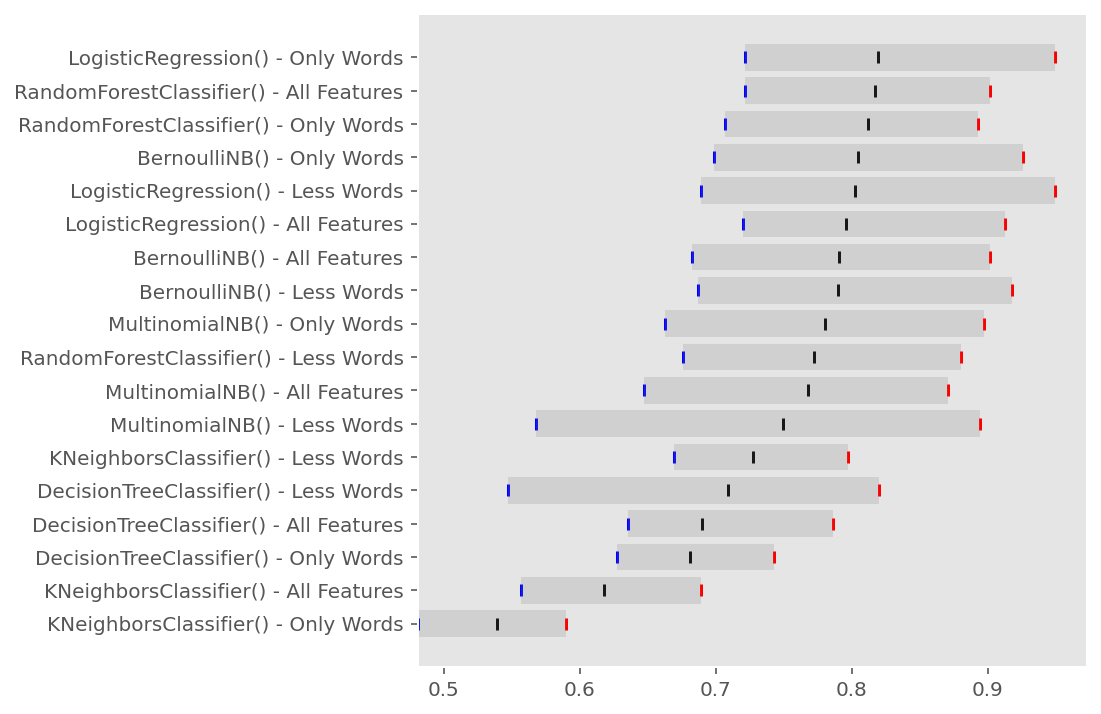

In [96]:
plt.figure(figsize=(6,6));
plt.grid(False)
plt.scatter(df_plot['min'], df_plot.index, marker='|', color='blue')
plt.scatter(df_plot['max'], df_plot.index, marker='|', color='red')
plt.scatter(df_plot['mean'], df_plot.index, marker='|', color='black');
plt.barh(df_plot.index, left=df_plot['min'], width=df_plot['variance'], alpha=0.2, color='grey');
plt.savefig('../plot_pdfs/newsletter/or/score_comparison_plot_openrate.jpeg')


In [101]:
#Reload & save the model

X = df[['month', 'stemmed_subject']].copy()
y = df['or_flag'].copy()

preprocessing = ColumnTransformer([('time_cat', OneHotEncoder(), ['month']),
                               ('words', CountVectorizer(stop_words=stop), 'stemmed_subject')])

pipeline_or = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', RandomForestClassifier())])

pipeline_or.fit(X, y)

joblib.dump(pipeline_or, '../saved_models/newsletter/pipeline_or.jlib')

['../saved_models/newsletter/pipeline_or.jlib']

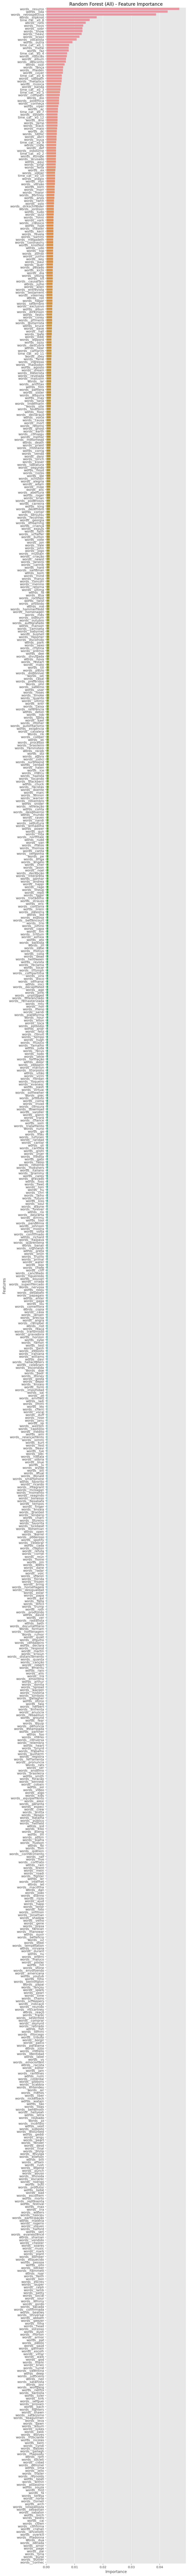

In [102]:
df_best = pd.DataFrame({'features':pipeline_or.steps[0][1].get_feature_names(), 'importance':pipeline_or.steps[1][1].feature_importances_})
df_best.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(8,150))
sns.barplot(x=df_best.importance, y=df_best.features)
plt.title('Random Forest (All) - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features');
# plt.savefig('../plot_pdfs/newsletter/or/final_features_openrate.pdf')

In [103]:
df_best.to_csv('../data/newsletter/openrate_features.csv', index=False)

In [104]:
df_best.head(10)

,features,importance
689,words__resumo,0.046890
484,words__lida,0.042794
693,words__retrospectiva,0.038710
777,words__slipknot,0.017753
7,time_cat__x0_8,0.015274
713,words__rock,0.013929
574,words__novo,0.013008
783,words__sobr,0.012760
768,words__show,0.012737
375,words__heavi,0.012497


### Conclusion

See newsletter_ctor notebook.